<a href="https://colab.research.google.com/github/kay-squared/PyTorchLearn/blob/main/02_PyTorch_NN_classification_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch
Resources:

https://www.learnpytorch.io/02_pytorch_classification/

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb

Questions in https://github.com/mrdbourke/pytorch-deep-learning/discussions

## 1. Prepare a toy classification data set for binary classification

Scikitlearn has a lot of tool to generate ttoy datasets:

https://scikit-learn.org/stable/datasets/toy_dataset.html

In [211]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np


### 1.0 Create data

In [212]:
# make 1000 samples
n_samples=1000
# create circles
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

print(len(X), len(y))
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")


1000 1000
First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [213]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "y": y})
circles.head()

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


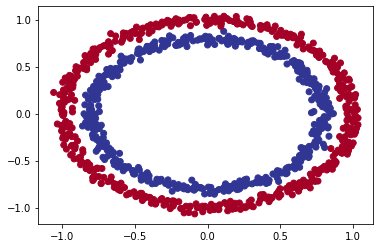

In [214]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [215]:

X_sample= X[0]
y_sample=y[0]
print(f"Values for one sample of X: {X_sample} and y: {y_sample}")
print(f"Shapes of data: X: {X.shape} and y: {y.shape}")


Values for one sample of X: [0.75424625 0.23148074] and y: 1
Shapes of data: X: (1000, 2) and y: (1000,)


### 1.2 Turn data into tensors and create train and test splits

In [216]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(X[:3],y[:3])
print(type(X),X.dtype,y.dtype)

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733]]) tensor([1., 1., 1.])
<class 'torch.Tensor'> torch.float32 torch.float32


In [217]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(f"Size of traininig set: X: {X_train.shape} and y: {y_train.shape}")
print(f"Size of test set: X: {X_test.shape} and y: {y_test.shape}")


Size of traininig set: X: torch.Size([800, 2]) and y: torch.Size([800])
Size of test set: X: torch.Size([200, 2]) and y: torch.Size([200])


## 2. Building a model

1. Set up device agnostic code
2. Construct a model by subclassing nn.Module
3. Define a loss function and optimizer
4. Create an train and test loop

### 2.1 Device agnostic code

later: send model and data to device

In [218]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### 2.1.1 Construct a Model

1. Subclass nn.Module 
2. Create 2 linear layers that are capable of handlnig the shapes of our data)
3. define a forward pass
4. Instantiate and send to target devcie

Check our http://playground.tensorflow.org/ for different architectures

In [219]:
# 1. subclassing
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    #2. Create 2 layers
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)
    
    #self.two_linear_layers= nn.Sequential(
    #    nn.Linear(in_features=2,out_features=5),
    #    nn.Linear(in_features=5,out_features=1)
    #)
    
    # 3. forward pass
    def forward(self,x):
      return self.layer_2(self_layer_1(x))
      #return self.two_linear_layers(x)

# 4. instatiate and send to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [220]:
next(model_0.parameters()).device

device(type='cuda', index=0)

### 2.1.2 Constructing the model another way

This is simpler, but for more complicated NN, the first way will prevail

In [221]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
)
model_0 = model_0.to(device)

In [222]:
model_0.state_dict()


OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

### The result of this model 
is, at the moment, still a real number, not a category: check that out

In [223]:
# check out predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
  print(f"\n First 10 predictions: \n {untrained_preds[:10]}")
  print(f"\n First 10 labels: \n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

 First 10 predictions: 
 tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

 First 10 labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.2 Cost function and optimizer

* As a loss function, use binary cross entropy or categorical cross entropy For reading up on binary cross entropy check out https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a by Daniel Godoy.  Note. that usinig BCEWithLogit implement the sigmoidal activation function, so you dont have to impelement it expliicitely in the last layer, whereas BCELoss does not - and requires explicit implementation. THe BCEWithLogit uses some trick and is numerically more stable!
* As an optimizer, use Adam() or SGD(). (see torch.optim)



In [224]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

### Create a evaluation metric:

* $ACC = frac{TP+TN}{TP+TN+FP+FN}

In [225]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))
  return acc



## 3. Train model

1. Forward pass
2. Loss
3. zero_grad
4. backpropagation (loss.backward())
5. gradient descent (optimizer.step())



### 3.1 Logit --> prediction probabiliity --> prediction labels

** This is needed for the prediction of accuracy! **

The raw outputs of the model will be **logits** that have to be converted into **prediction probabilities** by passing then through an activation function (eg sigmoid for binary classification and softmax for multiclass classification)

Then the prodiction probabilities can vbe turned intp **prediction lables** by rounding or by taking the argmax()

For the predicted labels, we need to perform a range-sttyle rounding on them:
* y_pred_probs>=0.5 --> y=1
* y_pred_probs<0.5 --> y=0


In [226]:
model_0.eval()
# check it out
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))
  y_logits[:5]
  y_pred_probs = torch.sigmoid(y_logits)
  #print(y_pred_probs[:5])
  #print(torch.round(y_pred_probs[:5]))

# this is how it is done
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)))).squeeze()
print(y_pred_labels[:5])
print(y_test[:5].to(device))


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([1., 0., 1., 0., 1.], device='cuda:0')


In [227]:
 
 torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
 

Epoch: 0 | Loss: 0.69796, Accuracy: 0.52% | Test loss: 0.69440, Test acc: 0.58%
Epoch: 10 | Loss: 0.69590, Accuracy: 0.51% | Test loss: 0.69305, Test acc: 0.53%
Epoch: 20 | Loss: 0.69490, Accuracy: 0.52% | Test loss: 0.69254, Test acc: 0.49%
Epoch: 30 | Loss: 0.69435, Accuracy: 0.51% | Test loss: 0.69236, Test acc: 0.49%
Epoch: 40 | Loss: 0.69401, Accuracy: 0.51% | Test loss: 0.69232, Test acc: 0.51%
Epoch: 50 | Loss: 0.69378, Accuracy: 0.50% | Test loss: 0.69234, Test acc: 0.50%
Epoch: 60 | Loss: 0.69362, Accuracy: 0.50% | Test loss: 0.69239, Test acc: 0.52%
Epoch: 70 | Loss: 0.69351, Accuracy: 0.50% | Test loss: 0.69246, Test acc: 0.51%
Epoch: 80 | Loss: 0.69342, Accuracy: 0.50% | Test loss: 0.69254, Test acc: 0.50%
Epoch: 90 | Loss: 0.69336, Accuracy: 0.50% | Test loss: 0.69262, Test acc: 0.53%


In [228]:
import requests
from pathlib import Path
# Download helper functions from Learn PyTorch rep
if Path('helper_functions.py').is_file():
  print('helper_function.py already exists, skipping download')
else:
  print('Downloading helper_functions.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")   # must be raw file
  with open('helper_functions.py','wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary



helper_function.py already exists, skipping download


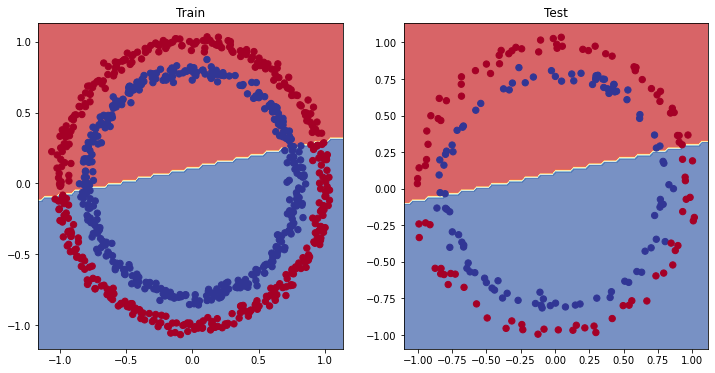

In [229]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Clearly, this model is too simple to represent the data well!

In [230]:
# 1. subclassing
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    #2. Create 2 layers
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10)
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)
    
    #self.two_linear_layers= nn.Sequential(
    #    nn.Linear(in_features=2,out_features=5),
    #    nn.Linear(in_features=5,out_features=1)
    #)
    
    # 3. forward pass
  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))
      



In [231]:
# 4. Instantiate and move to device
model_1 = CircleModelV1().to(device)
                             
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                      lr = 0.1)


torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch_count=[]
train_loss_list = []
test_loss_list = []
acc_train_list = []
acc_test_list=[]

epochs = 1000

for epoch in np.arange(epochs):
  # Training
  model_1.train()

  y_logits_train = model_1(X_train).squeeze()
  y_pred_train = torch.round(torch.sigmoid(y_logits_train))
  train_acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred_train)
  
  train_loss = loss_fn(y_logits_train,y_train)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    y_logits_test = model_1(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))
    test_acc = accuracy_fn(y_true = y_test,
                    y_pred = y_pred_test)
    
    if epoch%100==0:
      epoch_count.append(epoch)
      train_loss_list.append(train_loss.detach().cpu().numpy())
      test_loss_list.append(test_loss.detach().cpu().numpy())
      acc_train_list.append(train_acc)
      acc_test_list.append(test_acc)
      print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")










Epoch: 0 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69270, Test acc: 0.51%
Epoch: 100 | Loss: 0.69305, Accuracy: 0.50% | Test loss: 0.69270, Test acc: 0.48%
Epoch: 200 | Loss: 0.69299, Accuracy: 0.51% | Test loss: 0.69270, Test acc: 0.46%
Epoch: 300 | Loss: 0.69298, Accuracy: 0.52% | Test loss: 0.69270, Test acc: 0.45%
Epoch: 400 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69270, Test acc: 0.46%
Epoch: 500 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69270, Test acc: 0.46%
Epoch: 600 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69270, Test acc: 0.46%
Epoch: 700 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69270, Test acc: 0.46%
Epoch: 800 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69270, Test acc: 0.46%
Epoch: 900 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69270, Test acc: 0.46%


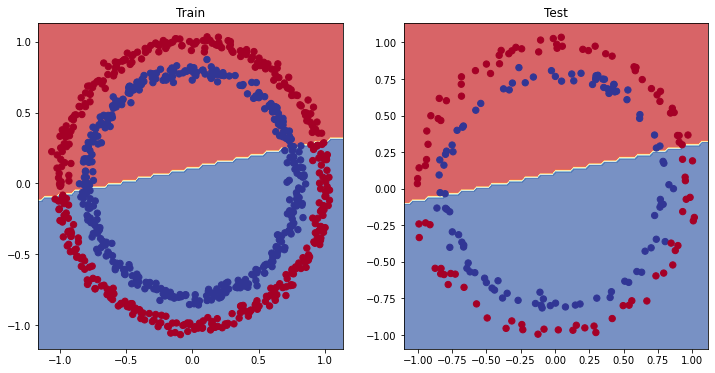

In [232]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Trouble Shooting: prepare data for checking whether model fits a straight line

In [233]:
# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]


# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

50
40 40 10 10


In [234]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)


In [235]:

# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    
      if epoch%100==0:
        epoch_count.append(epoch)
        train_loss_list.append(loss.detach().cpu().numpy())
        test_loss_list.append(test_loss.detach().cpu().numpy())
        
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")




Epoch: 0 | Loss: 0.69298 | Test loss: 0.54143
Epoch: 100 | Loss: 0.69298 | Test loss: 0.00881
Epoch: 200 | Loss: 0.69298 | Test loss: 0.01785
Epoch: 300 | Loss: 0.69298 | Test loss: 0.03021
Epoch: 400 | Loss: 0.69298 | Test loss: 0.01104
Epoch: 500 | Loss: 0.69298 | Test loss: 0.01172
Epoch: 600 | Loss: 0.69298 | Test loss: 0.02428
Epoch: 700 | Loss: 0.69298 | Test loss: 0.02345
Epoch: 800 | Loss: 0.69298 | Test loss: 0.00572
Epoch: 900 | Loss: 0.69298 | Test loss: 0.00978


### Debugging on a straight line

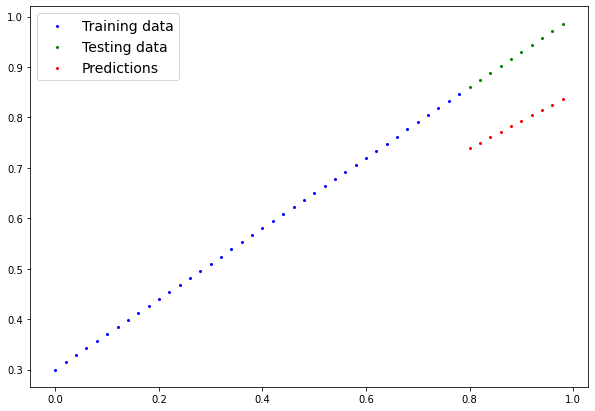

In [236]:
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions = y_preds.cpu())

### So try again

In [237]:
# 1. subclassing
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    #2. Create 2 layers
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10)
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)
    self.relu = nn.ReLU()
    #self.two_linear_layers= nn.Sequential(
    #    nn.Linear(in_features=2,out_features=5),
    #    nn.Linear(in_features=5,out_features=1)
    #)
    
    # 3. forward pass
  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
      



In [238]:
# 4. Instantiate and move to device
model_1 = CircleModelV1().to(device)
                             
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                      lr = 0.1)


torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch_count=[]
train_loss_list = []
test_loss_list = []
acc_train_list = []
acc_test_list=[]

epochs = 500

for epoch in np.arange(epochs):
  # Training
  model_1.train()

  y_logits_train = model_1(X_train).squeeze()
  y_pred_train = torch.round(torch.sigmoid(y_logits_train))
  train_acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred_train)
  
  train_loss = loss_fn(y_logits_train,y_train)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    y_logits_test = model_1(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))
    test_loss = loss_fn(y_logits_test,y_test)
    test_acc = accuracy_fn(y_true = y_test,
                    y_pred = y_pred_test)
    
    if epoch%20==0:
      epoch_count.append(epoch)
      train_loss_list.append(train_loss.detach().cpu().numpy())
      test_loss_list.append(test_loss.detach().cpu().numpy())
      acc_train_list.append(train_acc)
      acc_test_list.append(test_acc)
      print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69295, Accuracy: 0.50% | Test loss: 0.69394, Test acc: 0.50%
Epoch: 20 | Loss: 0.20353, Accuracy: 0.99% | Test loss: 0.19835, Test acc: 0.97%
Epoch: 40 | Loss: 0.01162, Accuracy: 1.00% | Test loss: 0.02676, Test acc: 0.99%
Epoch: 60 | Loss: 0.00364, Accuracy: 1.00% | Test loss: 0.01296, Test acc: 0.99%
Epoch: 80 | Loss: 0.00222, Accuracy: 1.00% | Test loss: 0.00857, Test acc: 1.00%
Epoch: 100 | Loss: 0.00168, Accuracy: 1.00% | Test loss: 0.00744, Test acc: 1.00%
Epoch: 120 | Loss: 0.00134, Accuracy: 1.00% | Test loss: 0.00670, Test acc: 1.00%
Epoch: 140 | Loss: 0.00111, Accuracy: 1.00% | Test loss: 0.00644, Test acc: 1.00%
Epoch: 160 | Loss: 0.00094, Accuracy: 1.00% | Test loss: 0.00609, Test acc: 1.00%
Epoch: 180 | Loss: 0.00082, Accuracy: 1.00% | Test loss: 0.00571, Test acc: 1.00%
Epoch: 200 | Loss: 0.00071, Accuracy: 1.00% | Test loss: 0.00543, Test acc: 1.00%
Epoch: 220 | Loss: 0.00062, Accuracy: 1.00% | Test loss: 0.00502, Test acc: 1.00%
Epoch: 240 | Loss: 0.0

### Evaluation of the model

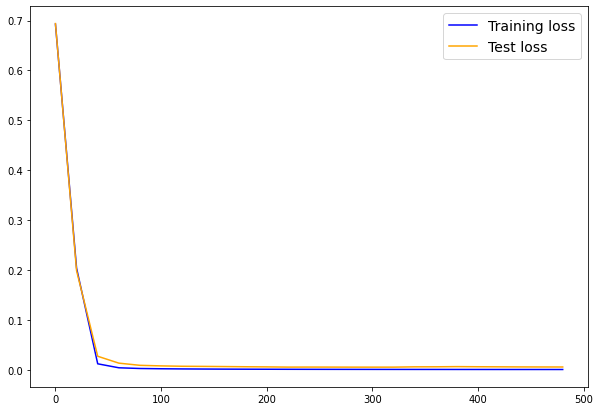

In [239]:
def plot_learning_curve(epoch_count, train_loss_list, test_loss_list):
  plt.figure(figsize=(10,7))
  plt.plot(epoch_count,train_loss_list,c="b", label="Training loss")
  plt.plot(epoch_count,test_loss_list,c="orange", label="Test loss")
  plt.legend(prop={"size": 14})

plot_learning_curve(epoch_count, train_loss_list, test_loss_list)

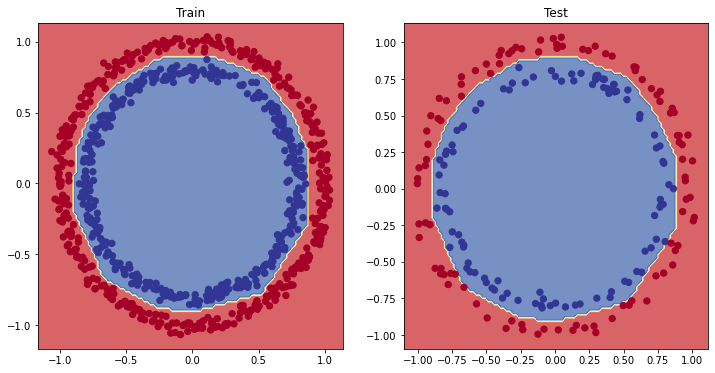

In [240]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [241]:
y_preds=[]
model_1.eval()
model_1 = model_1.to(device)
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()

y_preds,y_test

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
         1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
         0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
         0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
         1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
         1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
         1., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 

In [242]:
model_1.to(device)(X_test)

tensor([[ 12.8454],
        [-14.2900],
        [ 15.1340],
        [-19.4174],
        [  7.8013],
        [  6.8768],
        [-29.1895],
        [-22.6637],
        [ 12.1197],
        [-16.9342],
        [ -3.8661],
        [ 14.5788],
        [-30.4749],
        [ 14.5533],
        [ -5.4201],
        [ 12.2855],
        [ 14.1054],
        [-14.2690],
        [ 13.3116],
        [ -5.9766],
        [-20.4127],
        [-19.2035],
        [ 13.8279],
        [-23.4099],
        [-18.0439],
        [-17.9436],
        [-12.7937],
        [-25.9692],
        [-20.4154],
        [ 19.5808],
        [ 15.3393],
        [-17.2426],
        [ -7.5059],
        [ 10.1117],
        [-14.0864],
        [ 14.1358],
        [  5.9338],
        [ 13.1901],
        [ 11.7574],
        [ 18.0062],
        [ 11.0408],
        [ 14.4762],
        [ 15.1972],
        [-10.6373],
        [-14.9161],
        [ 12.9093],
        [ -5.0245],
        [-28.8454],
        [ 17.1806],
        [ 12.2053],


### Replication of non-linear thingies

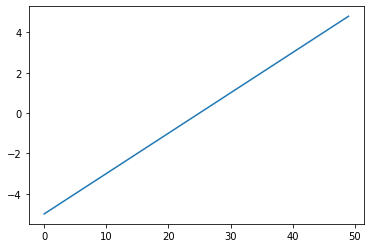

In [243]:
A = torch.arange(-5,5,0.2,dtype=torch.float32)
A
plt.plot(A)

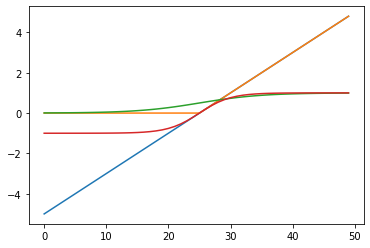

In [244]:
#compare activation functions
def relu(x):
  return torch.maximum(torch.tensor(0),x)
relu(A)

def sigmoid(x):
  return 1/(1+torch.exp(-x))
  
plt.plot(A)
plt.plot(relu(A))
plt.plot(sigmoid(A))
plt.plot(torch.tanh(A))

## Multiclass Classification Problems

* Use softmax activatoin vs sigmoid
* use cross entropy vs binary cross entroy

### 1. Create a dataset

In [245]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

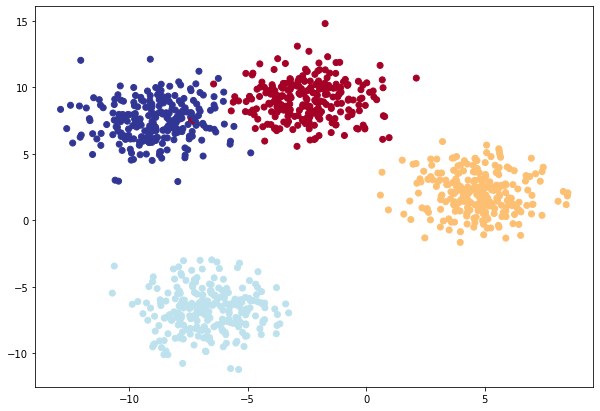

In [267]:
# hyperparameters for class creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size = 0.2, 
                                                                        random_state = RANDOM_SEED
                                                                        )

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap='RdYlBu')
X_blob_train.shape, X_blob_test.shape, y_blob_train.shape, y_blob_test.shape

In [268]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 2. Build the model

In [269]:
# 1. subclassing
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multiclass classification model.
    Args:  
      input_features (int): Number of input features to the model
      output_features(int): number of output features (output classes)
      hidden_units (int): number of hidden units between input and output layers, defaults to 8
    
    Returns:

    Example: 

    Errors:
    """
    super().__init__()
    self.LinearLayerStack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.LinearLayerStack(x)


    

#### The loss function
is the corss entropy loss, which can also take a weight for unbalanced data sets

In [270]:
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

print(model_4(X_blob_train.to(device)))

# prediction probabilities
logits = model_4(X_blob_train.to(device))
print(torch.softmax(logits, dim=1))

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        ...,
        [-0.2564, -1.2652, -1.0365, -0.3130],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.0502, -0.8423, -0.4798, -0.0988]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        ...,
        [0.3613, 0.1317, 0.1656, 0.3414],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3272, 0.1482, 0.2129, 0.3117]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [273]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count=[]
train_loss_list = []
test_loss_list = []
acc_train_list = []
acc_test_list=[]

X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

epochs = 500

for epoch in np.arange(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred_train = torch.softmax(y_logits, dim=1).argmax(dim=1)
  train_loss = loss_fn(y_logits, y_blob_train)
  
  train_acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred_train)
  
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()
  
  model_4.eval()
  with torch.inference_mode():
    y_logits_test = model_4(X_blob_test)
    test_loss = loss_fn(y_logits_test, y_blob_test)
    y_pred_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1)
    test_acc = accuracy_fn(y_true = y_blob_test,
                    y_pred = y_pred_test)
    
    if epoch%20==0:
      epoch_count.append(epoch)
      train_loss_list.append(train_loss.detach().cpu().numpy())
      test_loss_list.append(test_loss.detach().cpu().numpy())
      acc_train_list.append(train_acc)
      acc_test_list.append(test_acc)
      print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")







  

Epoch: 0 | Loss: 0.02377, Accuracy: 0.99 | Test loss: 0.01269, Test acc: 0.99
Epoch: 20 | Loss: 0.02369, Accuracy: 0.99 | Test loss: 0.01257, Test acc: 0.99
Epoch: 40 | Loss: 0.02361, Accuracy: 0.99 | Test loss: 0.01246, Test acc: 0.99
Epoch: 60 | Loss: 0.02354, Accuracy: 0.99 | Test loss: 0.01237, Test acc: 0.99
Epoch: 80 | Loss: 0.02346, Accuracy: 0.99 | Test loss: 0.01227, Test acc: 0.99
Epoch: 100 | Loss: 0.02339, Accuracy: 0.99 | Test loss: 0.01218, Test acc: 0.99
Epoch: 120 | Loss: 0.02332, Accuracy: 0.99 | Test loss: 0.01210, Test acc: 0.99
Epoch: 140 | Loss: 0.02326, Accuracy: 0.99 | Test loss: 0.01202, Test acc: 0.99
Epoch: 160 | Loss: 0.02319, Accuracy: 0.99 | Test loss: 0.01194, Test acc: 0.99
Epoch: 180 | Loss: 0.02313, Accuracy: 0.99 | Test loss: 0.01187, Test acc: 0.99
Epoch: 200 | Loss: 0.02307, Accuracy: 0.99 | Test loss: 0.01179, Test acc: 0.99
Epoch: 220 | Loss: 0.02301, Accuracy: 0.99 | Test loss: 0.01172, Test acc: 0.99
Epoch: 240 | Loss: 0.02295, Accuracy: 0.99 | T

In [272]:
y_blob_train[:5], model_4(X_blob_train)[:5]

(tensor([1, 0, 2, 2, 0], device='cuda:0'),
 tensor([[-2.6714, 10.0237, -8.7900, -9.9708],
         [ 5.3029, -6.5888, -9.2882, -3.9979],
         [-6.1105, -6.6315,  5.9143, -4.8882],
         [-3.8678, -4.2945,  4.1724, -3.2631],
         [ 2.8504, -5.7738, -6.7170, -1.6001]], device='cuda:0',
        grad_fn=<SliceBackward0>))